# **Spin Echo Exercise 4**

The sequence plays a single echotrain from a TSE-Sequence with echo train length 10..
Excitation is performed with an rf-pulse with phase zero, refocusing flip angles are < 180 in order to create signal via different refocusing pathways.
Lines 23 -28 of the sequence code contain different values for the phases of the refocussing pulses.
Try to figure out, which combinations lead to coherent superposition of the refocusing pathways (=CPMG-condition).
Ones you have guessed the answer, you can simulate the sequence.
Note: For the simulations you need to create the simulation object only once, you then need only the code in the last block to run the simulations.


In [ ]:
try:
  import pypulseq as mr
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  !pip install git+https://github.com/imr-framework/pypulseq.git
  import pypulseq as mr

pypulseq package is readily available



In [ ]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
!pip install MRzeroCore
import MRzeroCore as mr0

#import pypulseq as pp

TSE-sequence with single echo train.

In [ ]:
# ======
# SETUP
# ======

# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=100e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

fov = 256e-3  # Define FOV and resolution
Nx, Ny = 128, 128
n_echo = 16  # Number of echoes
n_slices = 1
#rf_flip = 180  # refocusing flip angle
rf_flip = [ 135, 90, 90, 90, 90, 90, 90, 90, 90, 90]
rf_ex_phase = 0 * np.pi / 2
rf_ref_phase = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#rf_ref_phase = [ 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
#rf_ref_phase = [ 180, 0, 180, 0, 180, 0, 180, 0, 180, 0]
#rf_ref_phase = [ 0, 180, 0, 180, 0, 180, 0, 180, 0, 180]
#rf_ref_phase = [ 0, 0, 180, 0, 180, 0, 180, 0, 180, 0]
#rf_ref_phase = [ 80, 60, 40, 20, 0, -20, -40, -60, -80, -100]

if isinstance(rf_flip, list):
  n_echo=len(rf_flip)

#if isinstance(rf_flip, int):
#    rf_flip = np.zeros(n_echo) + rf_flip
slice_thickness = 5e-3
TR = 500e-3   # Repetition time
TE1 = 12e-3    # Echo time for the first echo in the train
TE_eff = 60e-3 # Effective echo time that can be approximately achieved by an approapriate reordering

dG = 250e-6 # ramp time for many important gradients (makes sequence timing calculations much simpler)
sampling_time = 6.4e-3
readout_time = sampling_time + 2 * system.adc_dead_time
t_ex = 2.5e-3
t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time
t_ref = 2e-3
t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time
t_sp = 0.5 * (TE1 - readout_time - t_refwd)
t_spex = 0.5 * (TE1 - t_exwd - t_refwd)
fsp_r = 1
fsp_s = 0.5



plot: bool = True
write_seq: bool = True
seq_filename: str = "tse_pypulseq.seq"


TR fill: 369.61000000000007 ms
Timing check passed successfully
Plot the beginning of the sequence


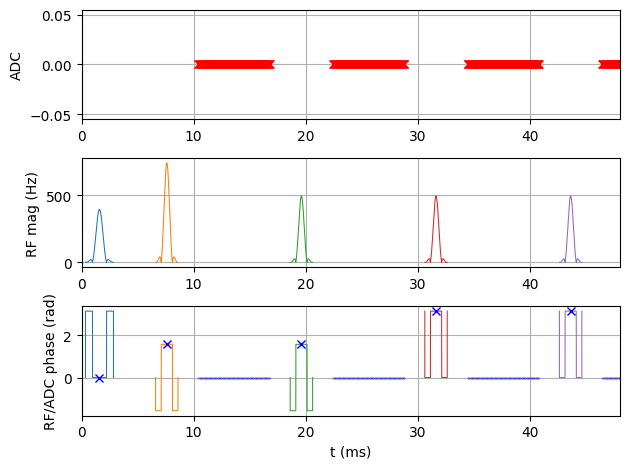

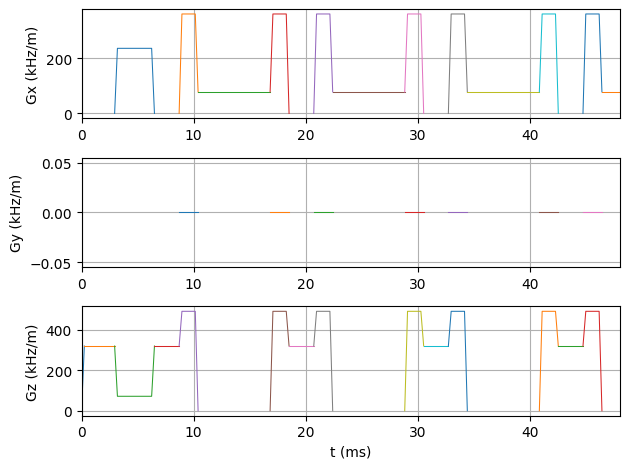

In [ ]:
# @title
# ======
# CREATE EVENTS
# ======
flip_ex = 90 * np.pi / 180
rf_ex, gz1, _ = mr.make_sinc_pulse(
    flip_angle=flip_ex,
    system=system,
    duration=t_ex,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=rf_ex_phase,
    return_gz=True,
)
gs_test = mr.make_trapezoid(
    channel="z",
    system=system,
    amplitude=gz1.amplitude,
    flat_time=t_exwd,
    rise_time=dG,
)
gs_ex = mr.make_trapezoid(
    channel="z",
    system=system,
    amplitude=gz1.amplitude,
    flat_time=t_exwd,
    rise_time=dG,
)

flip_ref = np.pi / 180
rf_ref, gz2, _ = mr.make_sinc_pulse(
    flip_angle=flip_ref,
    system=system,
    duration=t_ref,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=np.pi/180 * rf_ref_phase[1],
    use="refocusing",
    return_gz=True,
)
rf_envelope=rf_ref.signal

gs_ref = mr.make_trapezoid(
    channel="z",
    system=system,
    amplitude=gs_ex.amplitude, # why not gz2 (@JH)
    flat_time=t_refwd,
    rise_time=dG,
)

ags_ex = gs_ex.area / 2
gs_spr = mr.make_trapezoid(
    channel="z",
    system=system,
    area=ags_ex * (1 + fsp_s),
    duration=t_sp,
    rise_time=dG,
)
gs_spex = mr.make_trapezoid(
    channel="z", system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=dG
)

delta_k = 1 / fov
k_width = Nx * delta_k

gr_acq = mr.make_trapezoid(
    channel="x",
    system=system,
    flat_area=k_width,
    flat_time=readout_time,
    rise_time=dG,
)
adc = mr.make_adc(
    num_samples=Nx, duration=sampling_time, delay=system.adc_dead_time
)
gr_spr = mr.make_trapezoid(
    channel="x",
    system=system,
    area=gr_acq.area * fsp_r,
    duration=t_sp,
    rise_time=dG,
)

agr_spr = gr_spr.area
agr_preph = gr_acq.area / 2 + agr_spr
gr_preph = mr.make_trapezoid(
    channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG
)

# Phase-encoding
n_ex = math.floor(Ny / n_echo)
pe_steps = np.arange(1, n_echo * n_ex + 1) - 0.5 * n_echo * n_ex - 1

# adding these two lines (centering of the central echo band) could be a topic of an exercise
if divmod(n_echo, 2)[1] == 0:
    pe_steps = np.roll(pe_steps, [0, int(-np.round(n_ex / 2))])

pe_order = pe_steps.reshape((n_ex, n_echo), order="F").T

# adjusting the reordering to approximate TE_eff
i_pe_min=np.argmin(np.abs(pe_steps), axis=0);
k0_curr=int(np.floor((i_pe_min)/n_ex)) # calculate the 'native' central echo index
k0_prescr=int(np.max(np.array([np.round(TE_eff/TE1),1]))-1); # echo to be aligned to the k-space center
pe_order=np.roll(pe_order,shift=k0_prescr-k0_curr,axis=0);

phase_areas = pe_order * delta_k

# Split gradients and recombine into blocks
gs1_times = np.array([0, gs_ex.rise_time])
gs1_amp = np.array([0, gs_ex.amplitude])
gs1 = mr.make_extended_trapezoid(channel="z", times=gs1_times, amplitudes=gs1_amp)

gs2_times = np.array([0, gs_ex.flat_time])
gs2_amp = np.array([gs_ex.amplitude, gs_ex.amplitude])
gs2 = mr.make_extended_trapezoid(channel="z", times=gs2_times, amplitudes=gs2_amp)

gs3_times = np.array(
    [
        0,
        gs_spex.rise_time,
        gs_spex.rise_time + gs_spex.flat_time,
        gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time,
    ]
)
gs3_amp = np.array(
    [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
)
gs3 = mr.make_extended_trapezoid(channel="z", times=gs3_times, amplitudes=gs3_amp)

gs4_times = np.array([0, gs_ref.flat_time])
gs4_amp = np.array([gs_ref.amplitude, gs_ref.amplitude])
gs4 = mr.make_extended_trapezoid(channel="z", times=gs4_times, amplitudes=gs4_amp)

gs5_times = np.array(
    [
        0,
        gs_spr.rise_time,
        gs_spr.rise_time + gs_spr.flat_time,
        gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
    ]
)
gs5_amp = np.array([gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0])
gs5 = mr.make_extended_trapezoid(channel="z", times=gs5_times, amplitudes=gs5_amp)

gs7_times = np.array(
    [
        0,
        gs_spr.rise_time,
        gs_spr.rise_time + gs_spr.flat_time,
        gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time,
    ]
)
gs7_amp = np.array([0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude])
gs7 = mr.make_extended_trapezoid(channel="z", times=gs7_times, amplitudes=gs7_amp)

# Readout gradient
gr3 = gr_preph

gr5_times = np.array(
    [
        0,
        gr_spr.rise_time,
        gr_spr.rise_time + gr_spr.flat_time,
        gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
    ]
)
gr5_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude])
gr5 = mr.make_extended_trapezoid(channel="x", times=gr5_times, amplitudes=gr5_amp)

gr6_times = np.array([0, readout_time])
gr6_amp = np.array([gr_acq.amplitude, gr_acq.amplitude])
gr6 = mr.make_extended_trapezoid(channel="x", times=gr6_times, amplitudes=gr6_amp)

gr7_times = np.array(
    [
        0,
        gr_spr.rise_time,
        gr_spr.rise_time + gr_spr.flat_time,
        gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time,
    ]
)
gr7_amp = np.array([gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
gr7 = mr.make_extended_trapezoid(channel="x", times=gr7_times, amplitudes=gr7_amp)

# Fill-times
t_ex_b = mr.calc_duration(gs1) + mr.calc_duration(gs2) + mr.calc_duration(gs3)
t_ref_b = (
    mr.calc_duration(gs4)
    + mr.calc_duration(gs5)
    + mr.calc_duration(gs7)
    + readout_time
)
t_end = mr.calc_duration(gs4) + mr.calc_duration(gs5)

t_train = t_ex_b + n_echo * t_ref_b + t_end
TR_fill = (TR - n_slices * t_train) / n_slices
# Round to gradient raster
TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(
        f"TR too short, adapted to include all slices to: {1000 * n_slices * (TE_train + TR_fill)} ms"
    )
else:
    print(f"TR fill: {1000 * TR_fill} ms")
delay_TR = mr.make_delay(TR_fill)

# ======
# CONSTRUCT SEQUENCE
# ======
seq = mr.Sequence(system)  # Create a new sequence object

# populate the sequence object with event blocks
for k_ex in range(1):
    for s in range(n_slices):
        rf_ex.freq_offset = (
            gs_ex.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        )
        rf_ref.freq_offset = (
            gs_ref.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        )
        rf_ex.phase_offset = (
            rf_ex_phase
            - 2 * np.pi * rf_ex.freq_offset * mr.calc_rf_center(rf_ex)[0]
        )


        seq.add_block(gs1)
        seq.add_block(gs2, rf_ex)
        seq.add_block(gs3, gr3)

        for k_echo in range(n_echo):
            if k_ex > 0:
                phase_area = phase_areas[k_echo, k_ex - 1]
            else:
                phase_area = 0.0  # 0.0 and not 0 because -phase_area should successfully result in negative zero

            gp_pre = mr.make_trapezoid(
                channel="y",
                system=system,
                area=phase_area,
                duration=t_sp,
                rise_time=dG,
            )
            gp_rew = mr.make_trapezoid(
                channel="y",
                system=system,
                area=-phase_area,
                duration=t_sp,
                rise_time=dG,
            )
            rf_ref.signal= rf_flip[k_echo]*rf_envelope
            rf_ref.phase_offset = (
            rf_ref_phase[k_echo] * np.pi/180
            - 2 * np.pi * rf_ref.freq_offset * mr.calc_rf_center(rf_ref)[0]
        )
            seq.add_block(gs4, rf_ref)
            seq.add_block(gs5, gr5, gp_pre)
            if k_ex > -1:
                seq.add_block(gr6, adc)
            else:
                seq.add_block(gr6)

            seq.add_block(gs7, gr7, gp_rew)

        seq.add_block(gs4)
        seq.add_block(gs5)
        seq.add_block(delay_TR)

        # ======
# check whether the sequence timing is OK
# ======
(
    ok,
    error_report,
) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]


# ======
# VISUALIZATION
# ======
if plot:
  print("Plot the beginning of the sequence")
  seq.plot(time_range=[0, TE1*4], time_disp="ms") # just a small initial part
  #
  #print("Plot of the entire sequence")
  #seq.plot() # plot the entire sequence
  #
  #print("Plot of a single echo train")
  #seq.plot(time_range=np.array([0, TR-TR_fill])+TR, time_disp="ms") # plot one echo train

# =========
# WRITE .SEQ
# =========
if write_seq:
    seq.write(seq_filename)

    from google.colab import files
    #files.download(seq_filename)  # Download locally


Create MR-zero simulation object and run simulation. Needs to be run only once.

In [ ]:
# Download simulation object
!wget -O numerical_brain_cropped.mat https://github.com/mzaiss/MRTwin_pulseq/raw/mr0-core/data/numerical_brain_cropped.mat

--2024-02-05 12:03:31--  https://github.com/mzaiss/MRTwin_pulseq/raw/mr0-core/data/numerical_brain_cropped.mat
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mzaiss/MRTwin_pulseq/mr0-core/data/numerical_brain_cropped.mat [following]
--2024-02-05 12:03:32--  https://raw.githubusercontent.com/mzaiss/MRTwin_pulseq/mr0-core/data/numerical_brain_cropped.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178137 (174K) [application/octet-stream]
Saving to: ‘numerical_brain_cropped.mat’

numerical_brain_cro 100%[===================>] 173.96K  --.-KB/s    in 0.01s   

2024-02-05 12:03:32 (15.4 MB/s) - 

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


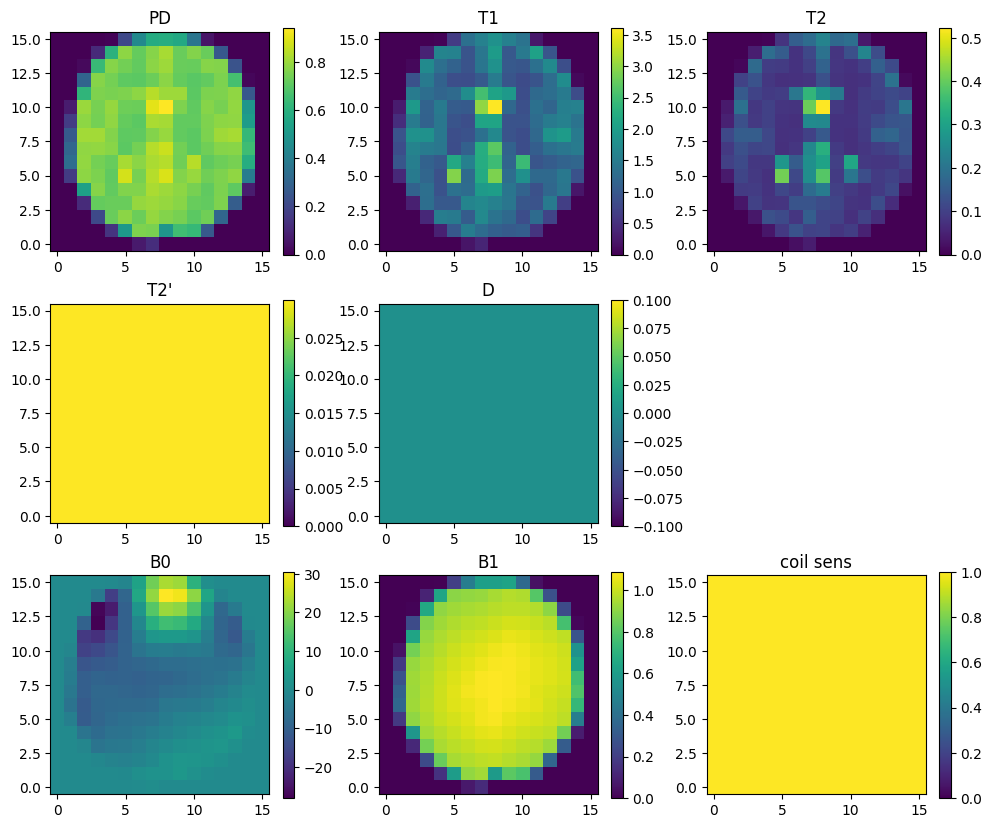

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


In [ ]:
# Object definition
sz = [16, 16]
dB0 = 0
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.B0 += dB0
obj_p.D *= 0
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

This performs the signal simulation.

Calculating repetition 11 / 11 - done
1280


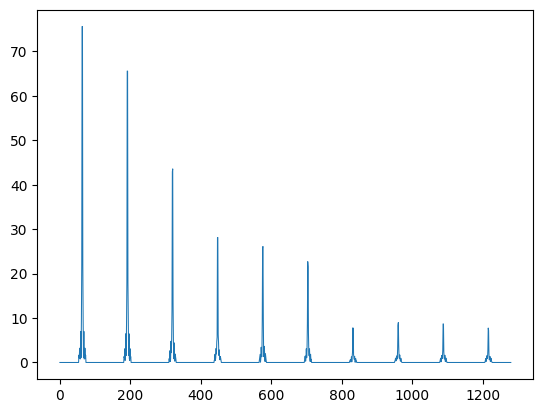

In [ ]:
# MR zero simulation
#seq0 = mr0.Sequence.from_seq_file(seq_filename)
seq0 = mr0.Sequence.import_file(seq_filename)
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-5)
signal = mr0.execute_graph(graph, seq0, obj_p)
kdata = signal.reshape(1,-1,adc.num_samples) # Reshape to [N_coils, N_meas, N_adc]
print(len(signal))
plt.plot(abs(signal))